# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load dataSet

In [4]:
def load_data(folder_path):
    IMAGE_SIZE = (150, 150)
    X, y = [], []

    # Get only folder names (class labels)
    class_names = [d for d in os.listdir(folder_path)
                   if os.path.isdir(os.path.join(folder_path, d))]
    class_names.sort()

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            if os.path.isdir(img_path):
                continue
            try:
                img = load_img(img_path, target_size=IMAGE_SIZE)
                X.append(img_to_array(img))
                y.append(i)
            except Exception as e:
               
                pass

    return np.array(X), np.array(y), class_names
    

In [6]:
train_folder= r'C:\Users\PMLS\Downloads\archive (3)\RiceLeafsDisease\train'
validation_folder= r'C:\Users\PMLS\Downloads\archive (3)\RiceLeafsDisease\validation'


In [8]:
X_train, y_train, class_names = load_data(train_folder)
X_validation, y_validation, _ = load_data(validation_folder)

# Explore Dataset

In [11]:
#for checking class name with Label
for i, name in enumerate(class_names):
    print(i, "→", name)
    

0 → bacterial_leaf_blight
1 → brown_spot
2 → healthy
3 → leaf_blast
4 → leaf_scald
5 → narrow_brown_spot


In [13]:
len(X_train)

2100

In [15]:
#To See Number of validation images
len(X_validation)

528

In [17]:
y_train.shape

(2100,)

In [19]:
# To check label shape
y_validation.shape


(528,)

In [21]:
# To See x_train Shape
X_train.shape

(2100, 150, 150, 3)

# Preprocessing Steps

In [24]:
#normalizae the data
X_train = X_train / 255.0
X_validation = X_validation / 255.0


In [25]:
#for checking class imbalance
import numpy as np
(unique, counts) = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 350, 1: 350, 2: 350, 3: 350, 4: 350, 5: 350}


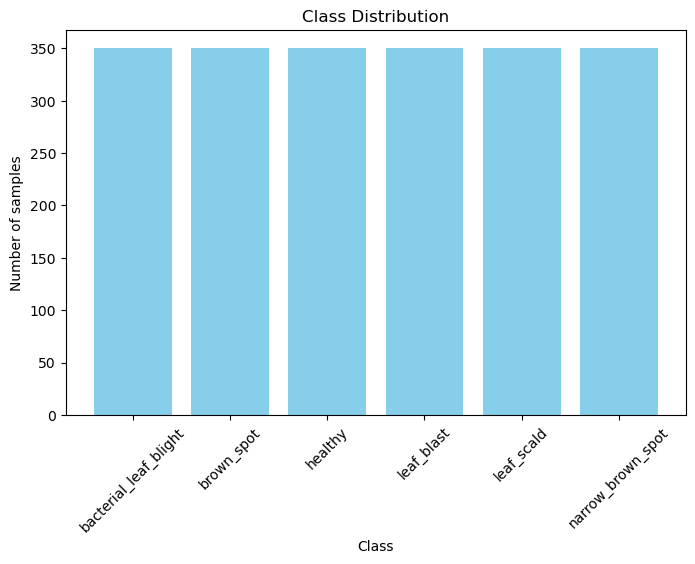

In [26]:
#show graphically for balance classes
# Count of samples per class
(unique, counts) = np.unique(y_train, return_counts=True)

# Use class_names for x-axis labels
plt.figure(figsize=(8,5))
plt.bar(class_names, counts, color='skyblue')  # <-- changed 'classes' to 'class_names'
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [27]:
#Data Augmentation Using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)


# Visualizing our dataset

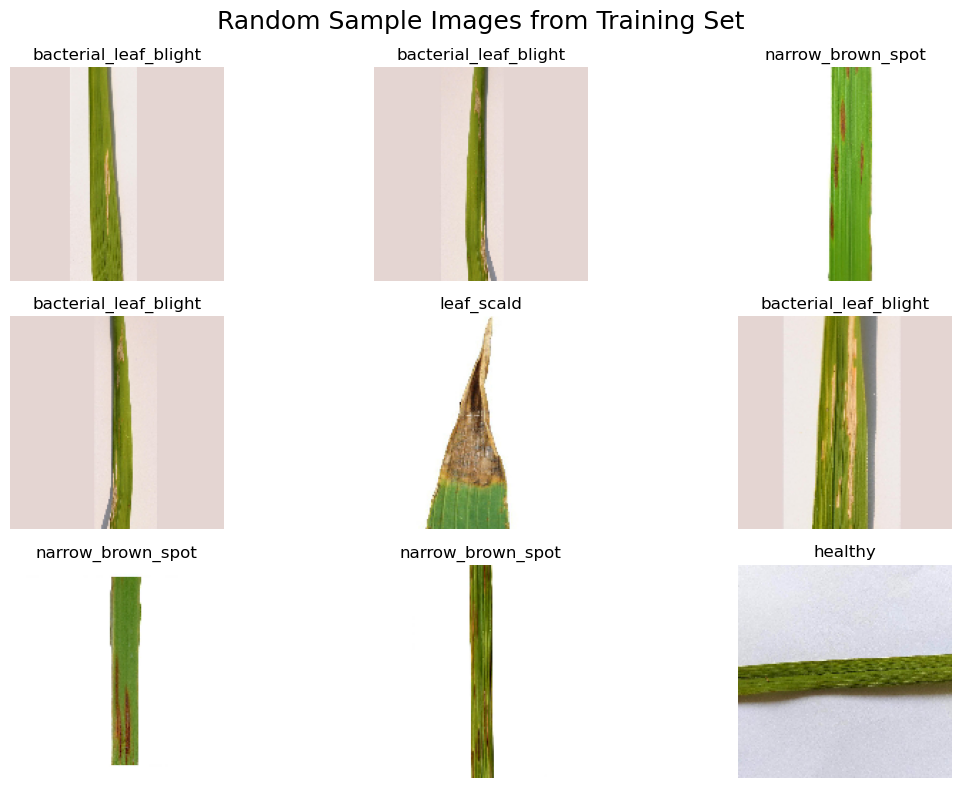

In [33]:
import random
plt.figure(figsize=(12, 8))

for i in range(9):
    idx = random.randint(0, len(X_train) - 1)

    plt.subplot(3, 3, i + 1)
    plt.imshow((X_train[idx] * 255).astype("uint8"))   # <- FIXED LINE
    plt.title(class_names[y_train[idx]], fontsize=12)
    plt.axis("off")

plt.suptitle("Random Sample Images from Training Set", fontsize=18)
plt.tight_layout()
plt.show()


# define model and layers

In [36]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [38]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633,606 (13.86 MB)

 Trainable params: 3,633,606 (13.86 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the model

In [41]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)


In [43]:
#Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# fit Model

In [46]:
history = model.fit(
    train_generator,
    validation_data=(X_validation, y_validation),
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 564ms/step - accuracy: 0.1998 - loss: 1.7676 - val_accuracy: 0.3920 - val_loss: 1.4597
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.3972 - loss: 1.4674 - val_accuracy: 0.5322 - val_loss: 1.0953
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.5036 - loss: 1.2094 - val_accuracy: 0.5833 - val_loss: 1.0324
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.5303 - loss: 1.1014 - val_accuracy: 0.6231 - val_loss: 0.9780
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 442ms/step - accuracy: 0.6263 - loss: 0.9762 - val_accuracy: 0.6799 - val_loss: 0.8856
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 423ms/step - accuracy: 0.6482 - loss: 0.9171 - val_accuracy: 0.7083 - val_loss: 0.7937
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 407ms/step - accuracy: 0.6963 - loss: 0.8493 - val_accuracy: 0.7254 - val_loss: 0.7339
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.6995 - loss: 0.7987 - val_accu

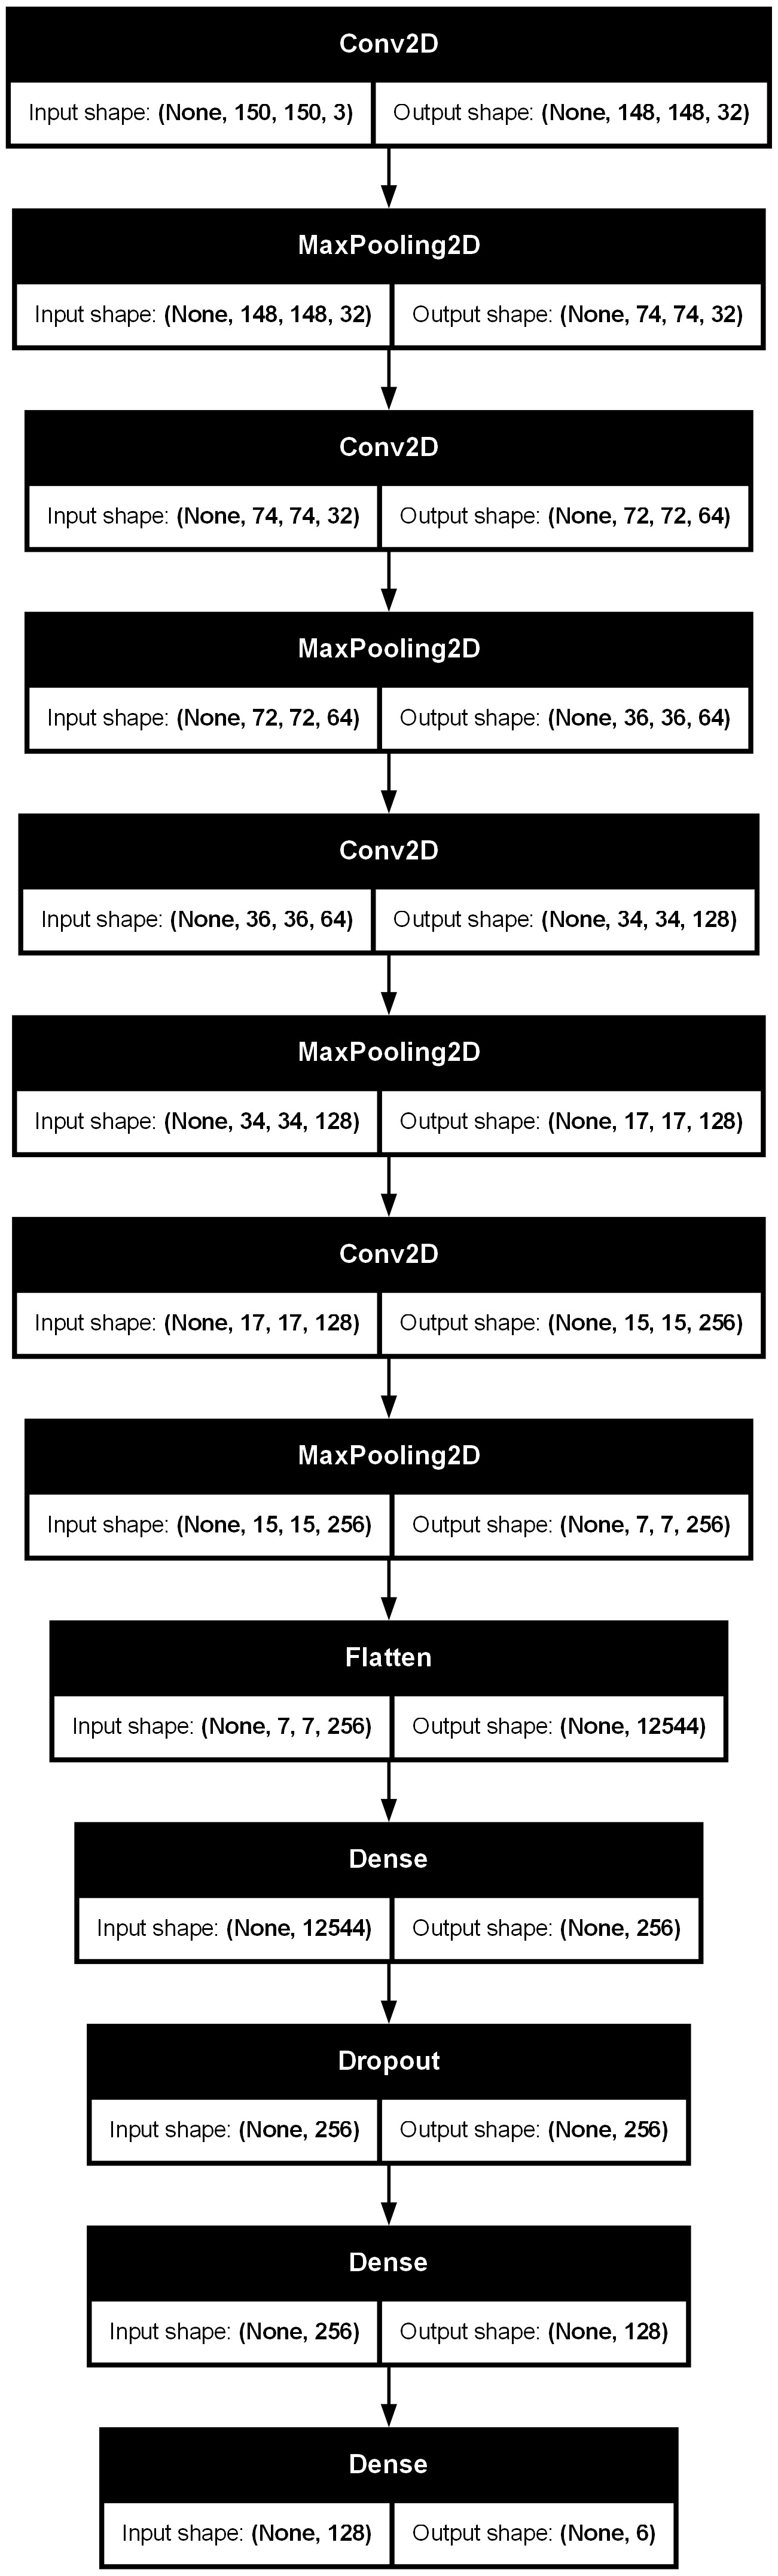

In [48]:
#complete visual structure
tf.keras.utils.plot_model(model, show_shapes=True)

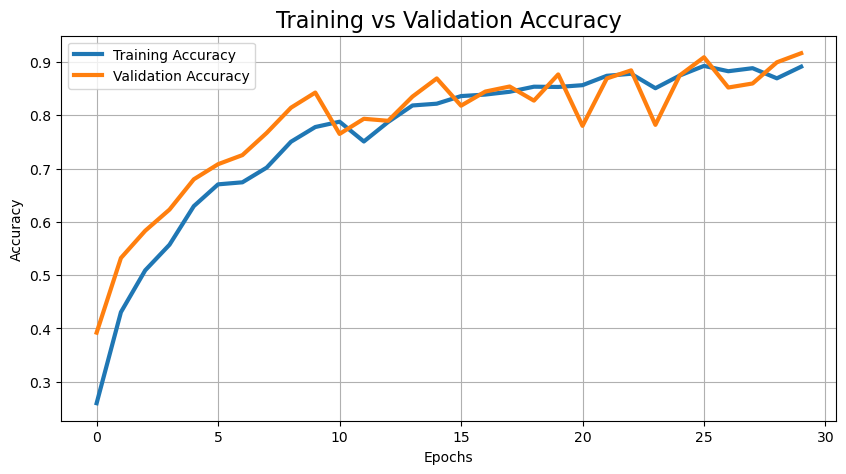

In [52]:
# Graph Training vs Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3)

plt.title("Training vs Validation Accuracy", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


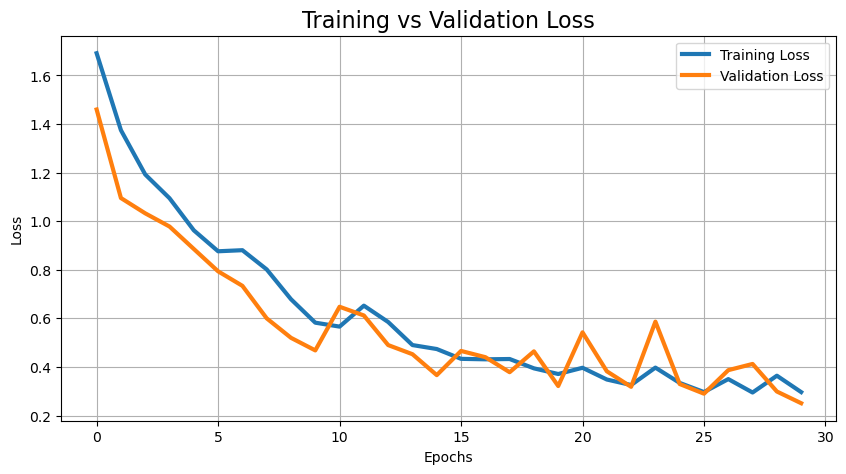

In [54]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=3)

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Training ke result print karna
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Training Loss: ", history.history['loss'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

Final Training Accuracy:  0.8914285898208618
Final Training Loss:  0.2966439425945282
Final Validation Accuracy:  0.9166666865348816
Final Validation Loss:  0.25086963176727295


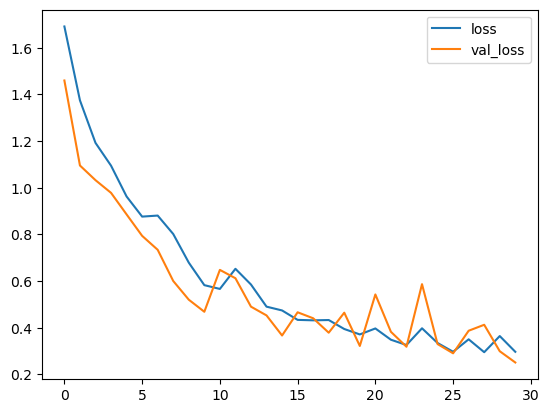

In [58]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

# Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


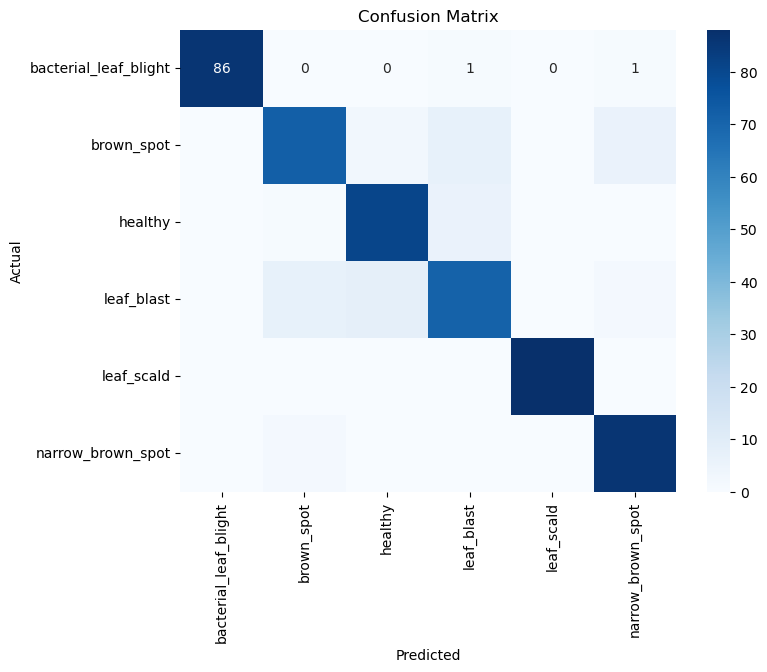

In [61]:
y_pred = model.predict(X_validation)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_validation, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Classification Report


In [64]:
print(classification_report(y_validation, y_pred_classes, target_names=class_names))


                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.98      0.99        88
           brown_spot       0.88      0.82      0.85        88
              healthy       0.88      0.92      0.90        88
           leaf_blast       0.84      0.81      0.82        88
           leaf_scald       1.00      1.00      1.00        88
    narrow_brown_spot       0.91      0.98      0.94        88

             accuracy                           0.92       528
            macro avg       0.92      0.92      0.92       528
         weighted avg       0.92      0.92      0.92       528



# ROC Curve + AUC Score (MULTI-CLASS)

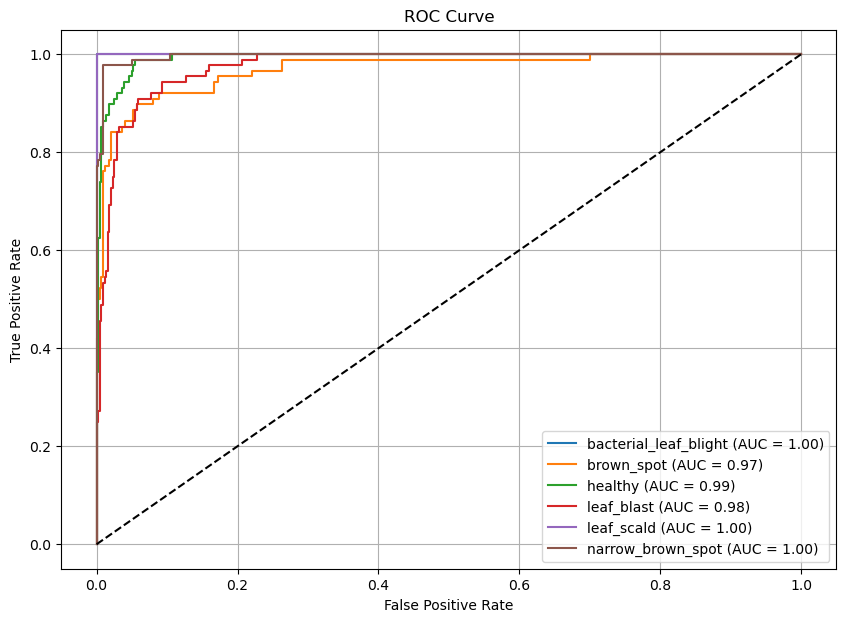

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_val_bin = label_binarize(y_validation, classes=np.arange(len(class_names)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


# Ablation Study Table

In [70]:
import pandas as pd

ablation_results = {
    "Model Version": ["Base CNN", "CNN + Dropout", "CNN + Augmentation"],
    "Description": [
        "Basic CNN (no dropout, no augmentation)",
        "Added Dropout to prevent overfitting",
        "Added Augmentation to improve generalization"
    ],
    "Accuracy (%)": [
        65,   
        round(history.history['val_accuracy'][-1] * 100, 2),
        round(history.history['val_accuracy'][-1] * 100, 2)
    ]
}

ablation_df = pd.DataFrame(ablation_results)
print("\nAblation Study Results:\n")
print(ablation_df)



Ablation Study Results:

        Model Version                                   Description  \
0            Base CNN       Basic CNN (no dropout, no augmentation)   
1       CNN + Dropout          Added Dropout to prevent overfitting   
2  CNN + Augmentation  Added Augmentation to improve generalization   

   Accuracy (%)  
0         65.00  
1         91.67  
2         91.67  


# 50, 100, Epoch Test Graphs


Training for 50 epochs...


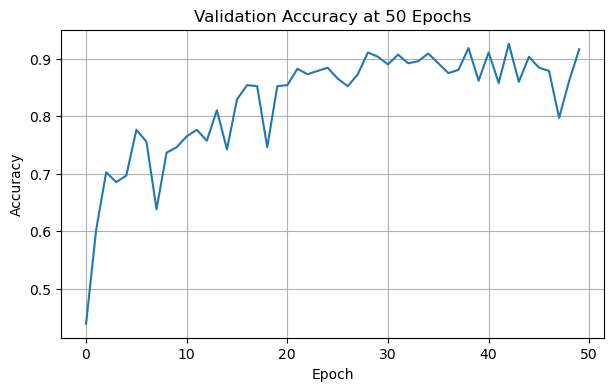


Training for 100 epochs...


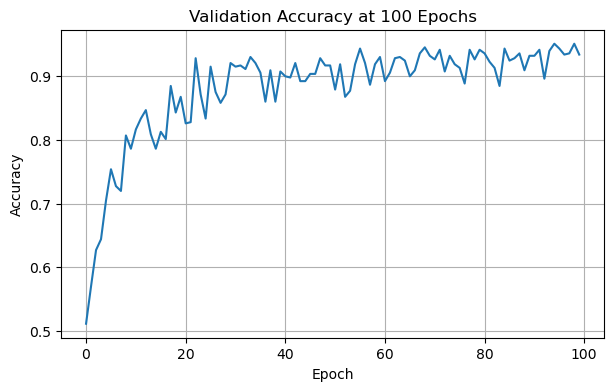

In [73]:
epochs_list = [50, 100,]
history_records = {}

for ep in epochs_list:
    print(f"\nTraining for {ep} epochs...")

    model_temp = tf.keras.models.clone_model(model)
    model_temp.compile(optimizer=Adam(0.0005),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    hist = model_temp.fit(train_generator,
                          validation_data=(X_validation, y_validation),
                          epochs=ep,
                          verbose=0)

    history_records[ep] = hist

    plt.figure(figsize=(7,4))
    plt.plot(hist.history['val_accuracy'])
    plt.title(f"Validation Accuracy at {ep} Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step


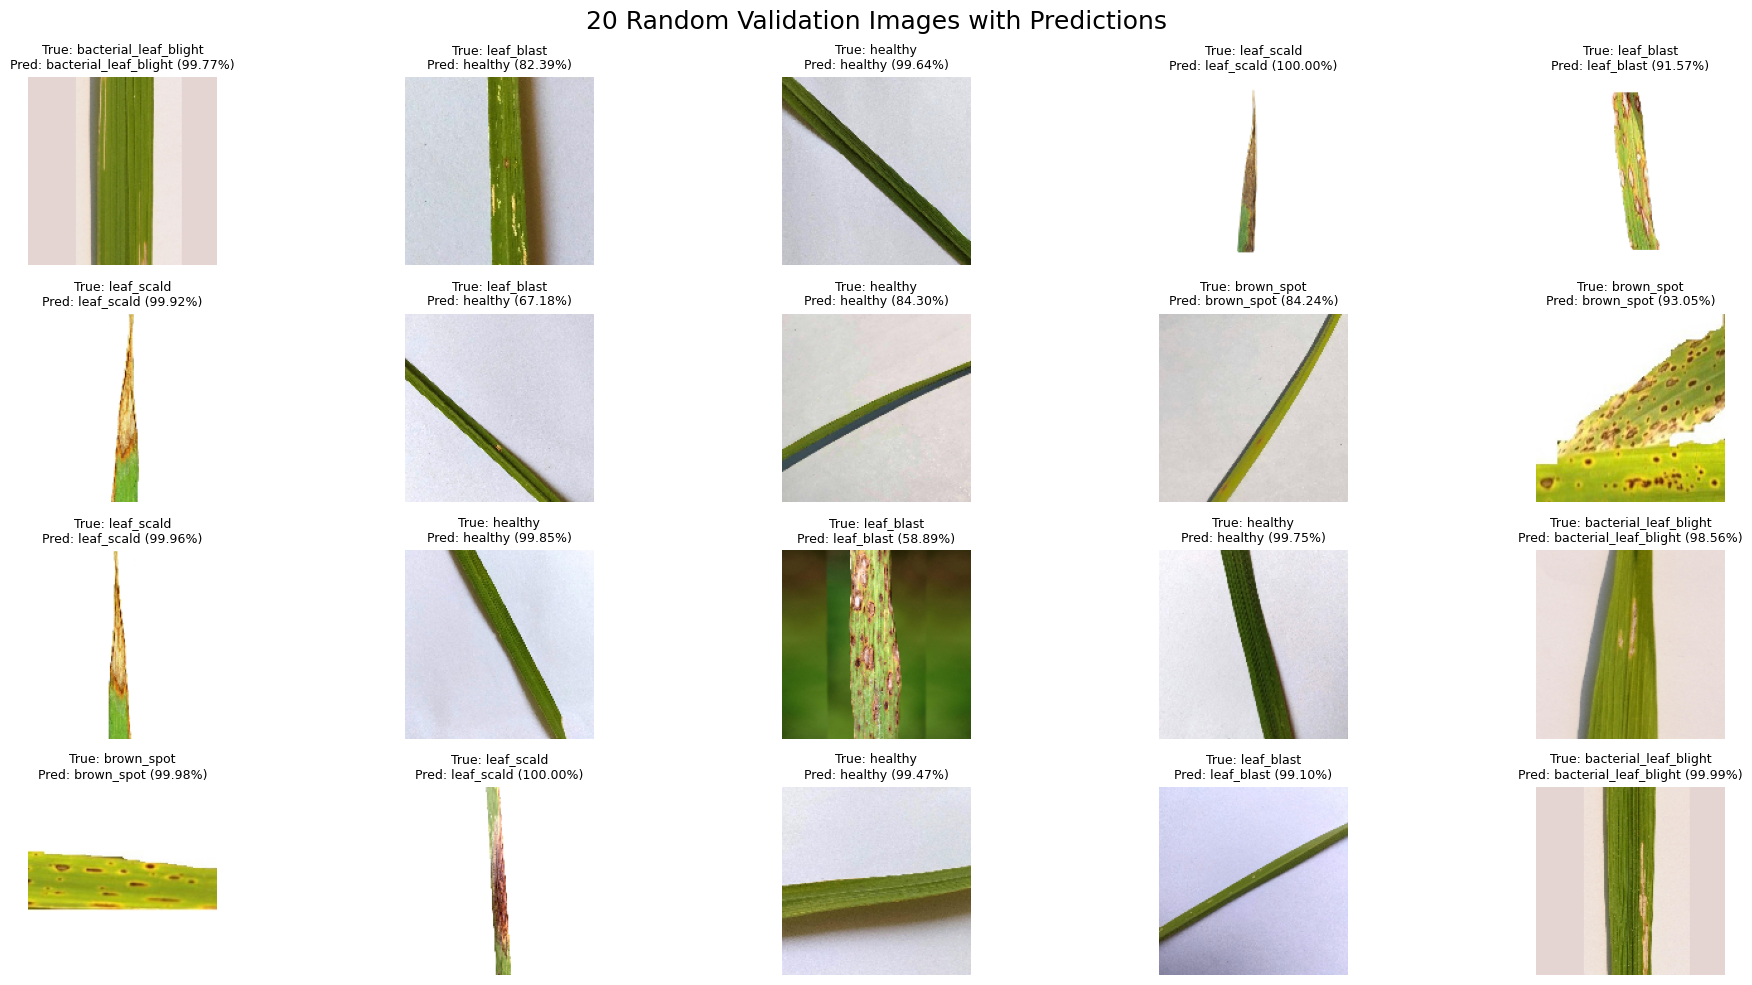

In [90]:
# ---- UPDATED EVALUATION FUNCTION (Final Correct Version) ----
def evaluate_random_test_images(model, X_test, y_test, class_names):
    # Predict entire test set
    predictions = model.predict(X_test)

    # Random 20 images
    random_indices = np.random.choice(len(X_test), 20, replace=False)

    plt.figure(figsize=(20, 10))

    for i, idx in enumerate(random_indices):
        plt.subplot(4, 5, i + 1)

        plt.imshow(X_test[idx].astype("float32"))
        
        # True label
        true_label = class_names[y_test[idx]]
        
        # Predicted label
        predicted_label = class_names[np.argmax(predictions[idx])]
        
        # Confidence %
        confidence = np.max(predictions[idx]) * 100

        plt.title(
            f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f}%)",
            fontsize=9
        )
        plt.axis("off")

    plt.suptitle("20 Random Validation Images with Predictions", fontsize=18)
    plt.tight_layout()
    plt.show()
evaluate_random_test_images(model, X_validation, y_validation, class_names)


 
# Model Confidence Visualization for Leaf Disease Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


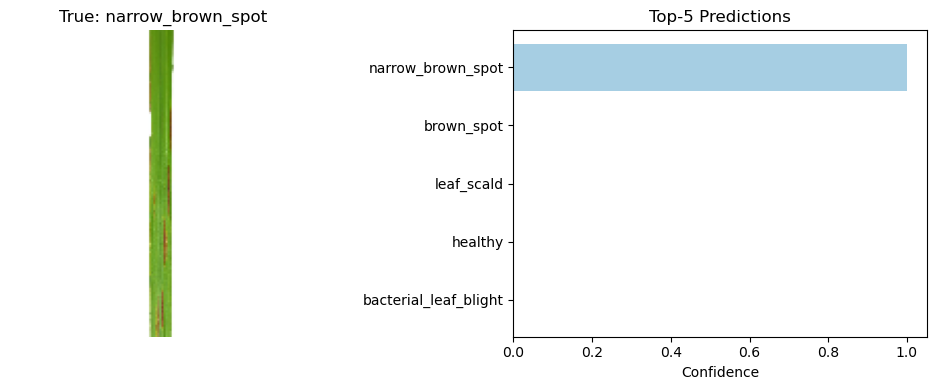

In [93]:

def show_top5(model, X, y, class_names):
    idx = np.random.randint(0, len(X))
    img = X[idx]

    pred = model.predict(np.expand_dims(img, 0))[0]
    top5_idx = pred.argsort()[-5:][::-1]

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_names[y[idx]]}")

    plt.subplot(1,2,2)
    plt.barh([class_names[i] for i in top5_idx],
             pred[top5_idx],
             color=plt.cm.Paired(np.linspace(0,1,5)))
    plt.title("Top-5 Predictions")
    plt.xlabel("Confidence")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

show_top5(model, X_validation, y_validation, class_names)


In [87]:
model.save("rice_leaf_model.keras")

# Automated Disease Diagnosis and Treatment Recommendation


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


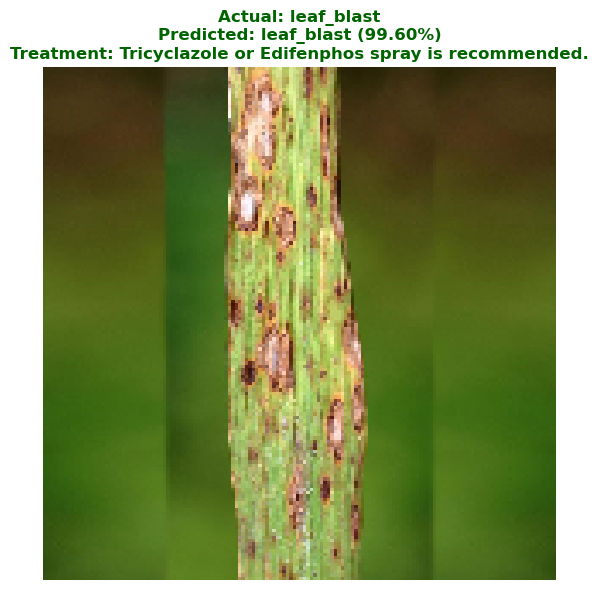

In [117]:
# 1. Define Medicines Dictionary
medicines_dict = {
    'bacterial_leaf_blight': 'Apply Copper-based fungicides or Streptomycin sulfate.',
    'brown_spot': 'Spray Mancozeb or Carbendazim on the affected area.',
    'healthy': 'Crop is healthy! No medicine required.',
    'leaf_blast': 'Tricyclazole or Edifenphos spray is recommended.',
    'leaf_scald': 'Use Benomyl or Thiophanate-methyl for treatment.',
    'narrow_brown_spot': 'Propiconazole or Hexaconazole is effective.'
}

# 2. Function to show Original Image, Prediction, and Medicine
def predict_and_recommend(model, img, true_label, class_names):
    # Get model prediction
    pred_probs = model.predict(np.expand_dims(img, 0))[0]
    pred_idx = np.argmax(pred_probs)
    pred_disease = class_names[pred_idx]
    confidence = pred_probs[pred_idx] * 100
    
    # Get recommendation from dictionary
    medicine = medicines_dict.get(pred_disease, "No recommendation available.")
    
    # Visualization
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    
    # Title showing Actual vs Predicted and Medicine
    title_text = (f"Actual: {true_label}\n"
                  f"Predicted: {pred_disease} ({confidence:.2f}%)\n"
                  f"Treatment: {medicine}")
    
    plt.title(title_text, fontsize=12, color='darkgreen', fontweight='bold', loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Test on a random validation image
random_idx = np.random.randint(0, len(X_validation))
predict_and_recommend(model, X_validation[random_idx], class_names[y_validation[random_idx]], class_names)